In [1]:
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
ozone_hourly = glob.glob('O3/*.csv')

In [3]:
dfs = []
for i in range(len(ozone_hourly)):
    df = pd.read_csv(ozone_hourly[i])
    dfs.append(df)

In [4]:
ozone_df = pd.concat(dfs)
ozone_df = ozone_df[['location_name','observation_hour_start','average_value_in_hour']]

In [5]:
ozone_df['observation_hour_start'] = pd.to_datetime(ozone_df['observation_hour_start'])

In [6]:
ozone_df.head()

,location_name,observation_hour_start,average_value_in_hour
0,"Alipur, Delhi - DPCC",2019-01-01 00:00:00,1.433333
1,"Alipur, Delhi - DPCC",2019-01-01 01:00:00,1.700000
2,"Alipur, Delhi - DPCC",2019-01-01 02:00:00,6.425000
3,"Alipur, Delhi - DPCC",2019-01-01 03:00:00,9.975000
4,"Alipur, Delhi - DPCC",2019-01-01 04:00:00,10.500000


In [7]:
station_dfs = []
# Create a DatetimeIndex with hourly frequency
date_range = pd.date_range(start='2019-01-01 00:00:00', end='2023-12-31 23:00:00', freq='H')
# Create a DataFrame with the datetime index
hours = pd.DataFrame(date_range, columns=['observation_hour'])

for station in tqdm(ozone_df.location_name.unique()):
    station_df = ozone_df[ozone_df.location_name == station].copy()
    station_df = hours.merge(station_df, left_on=['observation_hour'], right_on=['observation_hour_start'], how='left')
    station_df['running_mean_8h'] = station_df['average_value_in_hour'].rolling(window=8, min_periods=1).mean()
    station_df['location_name'] = station
    station_dfs.append(station_df[['observation_hour','location_name','average_value_in_hour','running_mean_8h']])

100%|██████████| 40/40 [00:02<00:00, 15.11it/s]


In [8]:
ozone_df = pd.concat(station_dfs)
ozone_df['date'] = ozone_df['observation_hour'].dt.date

In [9]:
ozone_df

,observation_hour,location_name,average_value_in_hour,running_mean_8h,date
0,2019-01-01 00:00:00,"Alipur, Delhi - DPCC",1.433333,1.433333,2019-01-01
1,2019-01-01 01:00:00,"Alipur, Delhi - DPCC",1.700000,1.566667,2019-01-01
2,2019-01-01 02:00:00,"Alipur, Delhi - DPCC",6.425000,3.186111,2019-01-01
3,2019-01-01 03:00:00,"Alipur, Delhi - DPCC",9.975000,4.883333,2019-01-01
4,2019-01-01 04:00:00,"Alipur, Delhi - DPCC",10.500000,6.006667,2019-01-01
...,...,...,...,...,...
43819,2023-12-31 19:00:00,"Lodhi Road, Delhi - IITM",NaN,NaN,2023-12-31
43820,2023-12-31 20:00:00,"Lodhi Road, Delhi - IITM",NaN,NaN,2023-12-31
43821,2023-12-31 21:00:00,"Lodhi Road, Delhi - IITM",NaN,NaN,2023-12-31
43822,2023-12-31 22:00:00,"Lodhi Road, Delhi - IITM",NaN,NaN,2023-12-31


In [13]:
mda8 = ozone_df.groupby(['location_name','date'])[['running_mean_8h']].max().reset_index()

In [14]:
mda8 = mda8.rename(columns={'running_mean_8h':'MDA'})

In [15]:
mda8.head()

,location_name,date,MDA
0,"Alipur, Delhi - DPCC",2019-01-01,57.881250
1,"Alipur, Delhi - DPCC",2019-01-02,60.276042
2,"Alipur, Delhi - DPCC",2019-01-03,51.006250
3,"Alipur, Delhi - DPCC",2019-01-04,27.103125
4,"Alipur, Delhi - DPCC",2019-01-05,49.873958


In [16]:
mda8_pivot = pd.pivot_table(mda8,
                          index='date',
                          columns='location_name',
                          values='MDA').reset_index()
mda8_pivot.set_index('date',inplace=True)
mda8_pivot['Median-MDA'] = mda8_pivot.median(axis=1)
mda8_pivot['Max-MDA'] = mda8_pivot.max(axis=1)
mda8_pivot['Mean-MDA'] = mda8_pivot.mean(axis=1)
mda8_pivot.to_csv('Median_MDA_Delhi.csv')

In [17]:
mda8_pivot

location_name,"Alipur, Delhi - DPCC","Anand Vihar, New Delhi - DPCC","Ashok Vihar, Delhi - DPCC","Aya Nagar, New Delhi - IMD","Bawana, Delhi - DPCC","Burari Crossing, New Delhi - IMD","CRRI Mathura Road, New Delhi - IMD","Chandni Chowk, Delhi - IITM","DTU, New Delhi - CPCB","Dr. Karni Singh Shooting Range, Delhi - DPCC",...,"Rohini, Delhi - DPCC","Shadipur, Delhi - CPCB","Sirifort, Delhi - CPCB","Sonia Vihar, Delhi - DPCC","Sri Aurobindo Marg, Delhi - DPCC","Vivek Vihar, Delhi - DPCC","Wazirpur, Delhi - DPCC",Median-MDA,Max-MDA,Mean-MDA
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,57.881250,26.040625,72.218750,34.780000,70.603125,26.870625,50.189688,NaN,76.982292,87.737500,...,67.218750,44.072812,83.543750,73.428125,8.009375,48.675000,34.746875,45.892708,316.250000,64.249906
2019-01-02,60.276042,62.628125,66.031250,39.605313,76.496875,27.909375,60.587813,NaN,69.309375,121.396875,...,58.309375,53.076250,98.859375,66.544792,6.165625,38.037500,34.471875,50.374844,416.000000,74.711471
2019-01-03,51.006250,28.125000,58.156250,43.291250,42.471875,38.347812,46.693438,NaN,73.975000,81.284375,...,64.225000,36.917292,80.428125,78.306250,77.115625,37.050000,25.893750,42.471875,82.284375,45.878119
2019-01-04,27.103125,29.475000,32.560714,39.885938,23.546875,66.556250,49.322500,NaN,48.934375,32.225000,...,39.942708,21.803438,68.496875,43.409375,34.014286,21.325000,15.462500,27.103125,68.496875,29.680737
2019-01-05,49.873958,34.006250,70.778571,41.305312,3.746875,48.276875,61.182812,NaN,60.653125,78.921875,...,50.028125,40.061667,90.637500,75.631250,48.340625,71.728125,20.059375,45.992188,345.312500,69.554688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,15.967083,23.166250,2.937500,39.384296,4.899167,19.863986,40.566881,NaN,28.378750,33.428542,...,7.532083,431.645000,19.557708,10.491667,15.985417,2.470000,NaN,19.710847,431.645000,45.321701
2023-12-28,23.757857,18.951042,4.191250,40.399563,8.922083,18.322584,39.404721,NaN,38.134583,28.194167,...,10.276429,24.717083,13.286111,19.363889,11.404167,5.145000,3.100000,22.684722,96.691667,27.018014
2023-12-29,19.060000,21.715833,3.306667,33.754302,5.496667,36.778544,39.403389,NaN,19.433750,9.508333,...,10.481667,24.135444,8.433333,10.566667,9.741667,29.500000,15.108333,16.271667,151.225000,25.349793


In [20]:
mda8_pivot['month'] = pd.to_datetime(mda8_pivot.index).month
mda8_pivot['year'] = pd.to_datetime(mda8_pivot.index).year

In [23]:
mean_mda = mda8_pivot.groupby(['year','month'])[['Mean-MDA']].mean().reset_index()
mean_mda.to_csv('Mean_MDA_Monthly_Delhi.csv', index=False)



In [17]:
max_mda_range = mda8_pivot.groupby(['year','month'])[['Max-MDA']].min().reset_index()
max_mda_range = max_mda_range.rename(columns={'Max-MDA':'Max-MDA_L'})
max_mda_range['Max-MDA_U'] = mda8_pivot.groupby(['year','month'])[['Max-MDA']].max().reset_index()['Max-MDA']
max_mda_range.to_csv('Max_MDA_Range_Monthly_Delhi.csv', index=False)

mean_mda_range = mda8_pivot.groupby(['year','month'])[['Mean-MDA']].min().reset_index()
mean_mda_range = mean_mda_range.rename(columns={'Mean-MDA':'Mean-MDA_L'})
mean_mda_range['Mean-MDA_U'] = mda8_pivot.groupby(['year','month'])[['Mean-MDA']].max().reset_index()['Mean-MDA']
mean_mda_range.to_csv('Mean_MDA_Range_Monthly_Delhi.csv', index=False)

In [49]:
max_mda_range = mda8_pivot.groupby(['year'])[['Max-MDA']].min().reset_index()
max_mda_range = max_mda_range.rename(columns={'Max-MDA':'Max-MDA_L'})
max_mda_range['Max-MDA_U'] = mda8_pivot.groupby(['year'])[['Max-MDA']].max().reset_index()['Max-MDA']
max_mda_range.to_csv('Max_MDA_Range_Yearly_Delhi.csv', index=False)

mean_mda_range = mda8_pivot.groupby(['year'])[['Mean-MDA']].min().reset_index()
mean_mda_range = mean_mda_range.rename(columns={'Mean-MDA':'Mean-MDA_L'})
mean_mda_range['Mean-MDA_U'] = mda8_pivot.groupby(['year'])[['Mean-MDA']].max().reset_index()['Mean-MDA']
mean_mda_range.to_csv('Mean_MDA_Range_Yearly_Delhi.csv', index=False)

In [19]:
mean_mda_range

location_name,year,month,Mean-MDA_L,Mean-MDA_U
0,2019,1,29.680737,92.369989
1,2019,2,30.192316,101.687770
2,2019,3,47.336534,118.014181
3,2019,4,63.805267,138.652499
4,2019,5,61.043703,156.001365
5,2019,6,59.945032,152.483117
6,2019,7,30.203793,115.571634
7,2019,8,21.940966,71.799747
8,2019,9,34.239123,107.989809
9,2019,10,14.780673,108.041436


In [15]:
agg = 'Mean-MDA'

mda8_pivot2 = mda8_pivot.reset_index().copy()
mda8_pivot2['date'] = pd.to_datetime(mda8_pivot2['date'])
mda8_pivot2['mm-yy'] = mda8_pivot2['date'].dt.strftime('%b-%d') #Remove year from timestamp
mda8_pivot2['year'] = mda8_pivot2['date'].dt.year #Remove year from timestamp

mda8_pivot2 = pd.pivot_table(mda8_pivot2,
                                     index=['mm-yy'],
                                     columns='year',
                                     values=agg).reset_index()

mda8_pivot2.set_index('mm-yy',inplace=True)


## SORT THE  DATETIME INDEX WHICH IS IN STRING FORMAT ##
# Convert the index to datetime
mda8_pivot2.index = pd.to_datetime(mda8_pivot2.index + '-2000', format='%b-%d-%Y')
# Sort the DataFrame by the datetime index
mda8_pivot2 = mda8_pivot2.sort_index()
# Remove the year from the index
mda8_pivot2.index = mda8_pivot2.index.strftime('%b-%d')
mda8_pivot2

year,2019,2020,2021,2022,2023
mm-yy,,,,,
Jan-01,64.249906,50.675982,46.595557,48.035877,45.537863
Jan-02,74.711471,46.529906,31.337230,43.473572,31.971160
Jan-03,45.878119,35.081165,25.205555,51.179044,29.466930
Jan-04,29.680737,50.427869,31.390794,38.337058,28.663071
Jan-05,69.554688,57.947435,31.003763,26.589717,22.468925
...,...,...,...,...,...
Dec-27,29.191073,70.879993,41.282833,32.398790,45.321701
Dec-28,26.412289,60.378844,14.978722,45.165093,27.018014
Dec-29,39.957335,63.723135,32.105548,50.652234,25.349793


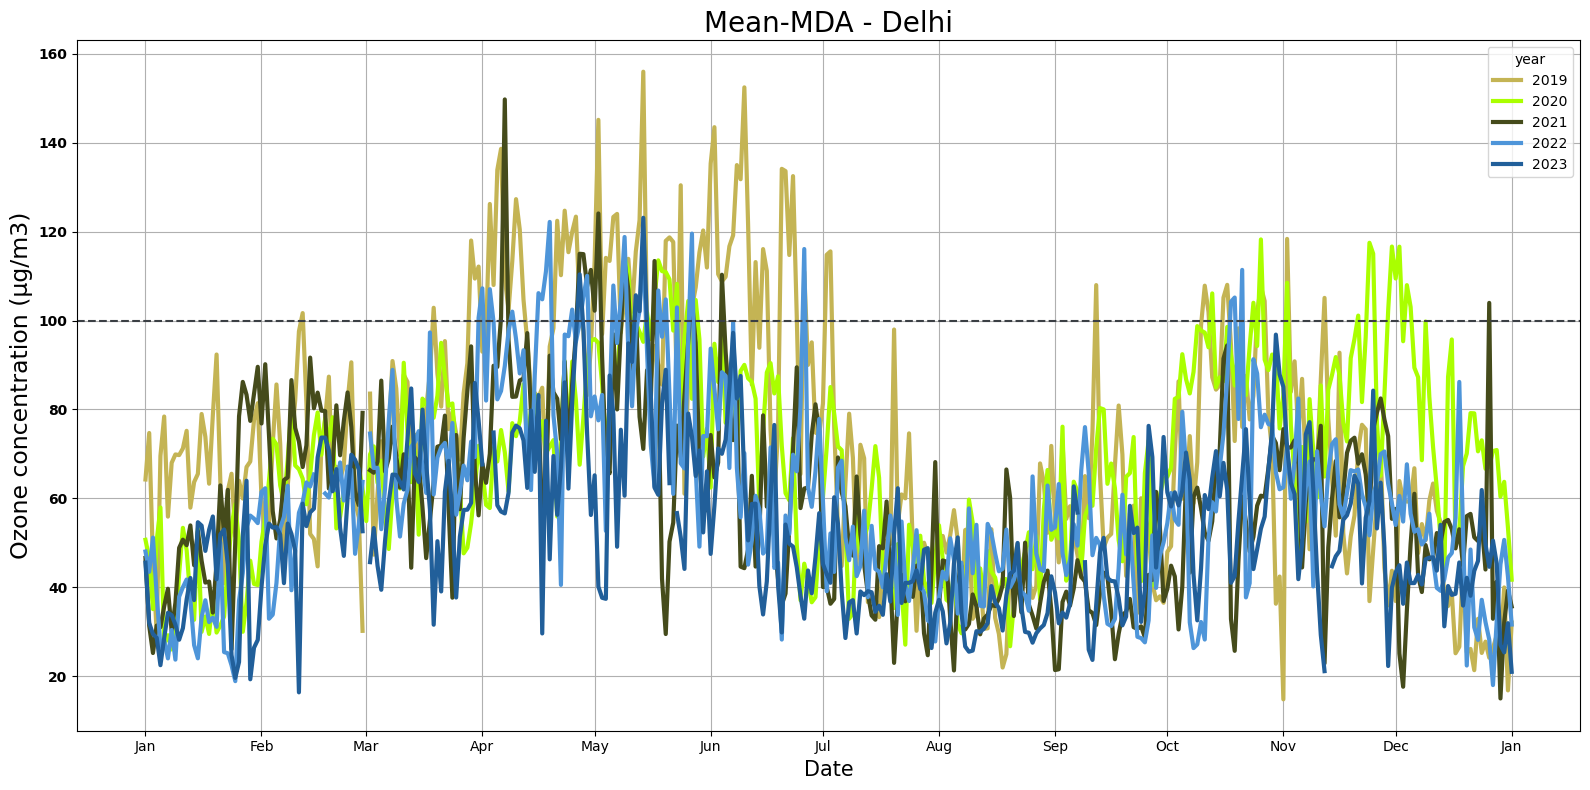

In [16]:
import matplotlib.dates as mdates

color_dict = {
              2019: '#C4B454',
              2020: '#AAFF00',
              2021: '#454B1B',
              2022: '#4e95d9',
              2023: '#215f9a',
              }
mda8_pivot2.plot(figsize=(16, 8),
                       color=[color_dict.get(x) for x in mda8_pivot2.columns],
                       linewidth = 3)

plt.title('{} - Delhi'.format(agg), fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Ozone concentration (μg/m3)', fontsize=17)

plt.yticks(fontweight='bold', fontsize=10)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid()
plt.axhline(y=100, color='#3B3F44', linestyle='--')

# Add data source annotation
#data_source_annotation = '''Data sourcsed from official AQI Bulletins'''

#plt.text(0.01, 0.02, data_source_annotation, fontsize=8, color='gray', transform=plt.gcf().transFigure)

# Load the image
#logo = plt.imread('assets/logo.grid.3_transp.png')  # Provide the path to your image file
#plt.figimage(logo, xo=1500, yo=0.02)
plt.tight_layout()
plt.savefig('Delhi_{}_seasonplot.png'.format(agg))
plt.show()

In [16]:
mda8 = mda8.set_index('date')

In [17]:
mda8.to_csv('MDA_Delhi.csv')

# O3 Exceedance

In [57]:
grouped = mda8.groupby('date')[['MDA']]

# For each day, what is the third largest MDA value in each station?
o3_exceedance = grouped.transform(lambda x: x.nlargest(3).min())
o3_exceedance['o3_exceedance'] = 'N'

# Update 'o3_exceedance' where 'mda' is greater than 100 to 'Y'
o3_exceedance.loc[o3_exceedance['MDA'] > 100, 'o3_exceedance'] = 'Y'
o3_exceedance['date'] = pd.to_datetime(mda8['date'])
o3_exceedance['year'] = o3_exceedance['date'].dt.year
o3_exceedance['mm'] = o3_exceedance['date'].dt.strftime('%b') #Remove year from timestamp
o3_exceedance = o3_exceedance.rename(columns={'MDA':'3rdmax_MDA'})
o3_exceedance = o3_exceedance.drop_duplicates(['date', 'o3_exceedance'])
o3_exceedance

,3rdmax_MDA,o3_exceedance,date,year,mm
0,106.390625,Y,2019-01-01,2019,Jan
1,121.396875,Y,2019-01-02,2019,Jan
2,80.428125,N,2019-01-03,2019,Jan
3,49.322500,N,2019-01-04,2019,Jan
4,121.450000,Y,2019-01-05,2019,Jan
...,...,...,...,...,...
1821,46.675545,N,2023-12-27,2023,Dec
1822,42.446779,N,2023-12-28,2023,Dec
1823,39.403389,N,2023-12-29,2023,Dec
1824,54.308125,N,2023-12-30,2023,Dec


In [58]:
o3_exceedance.groupby(['year', 'mm'])[['o3_exceedance']].value_counts().reset_index()

,year,mm,o3_exceedance,count
0,2019,Apr,Y,29
1,2019,Apr,N,1
2,2019,Aug,N,26
3,2019,Aug,Y,5
4,2019,Dec,N,21
...,...,...,...,...
111,2023,Nov,Y,15
112,2023,Oct,Y,20
113,2023,Oct,N,11
114,2023,Sep,N,23


In [62]:
tally = o3_exceedance.groupby(['year', 'mm'])[['o3_exceedance']].value_counts().reset_index()

tally = tally[tally.o3_exceedance == 'Y']
tally_pivot = pd.pivot_table(tally,
                          index='mm',
                          columns='year',
                          values='count').reset_index()
tally_pivot.set_index('mm',inplace=True)


## SORT THE  DATETIME INDEX WHICH IS IN STRING FORMAT ##
# Convert the index to datetime
tally_pivot.index = pd.to_datetime(tally_pivot.index + '-2000', format='%b-%Y')
# Sort the DataFrame by the datetime index
tally_pivot = tally_pivot.sort_index()
# Remove the year from the index
tally_pivot.index = tally_pivot.index.strftime('%b')


tally_pivot.to_csv('O3_Exceedances_Monthly_Delhi.csv')

In [63]:
tally = o3_exceedance.groupby('year')[['o3_exceedance']].value_counts().reset_index()

tally_pivot = pd.pivot_table(tally,
                          index=['o3_exceedance'],
                          columns='year',
                          values='count').reset_index()
tally_pivot.set_index('o3_exceedance',inplace=True)
tally_pivot.to_csv('O3_Exceedances_Yearly_Delhi.csv')

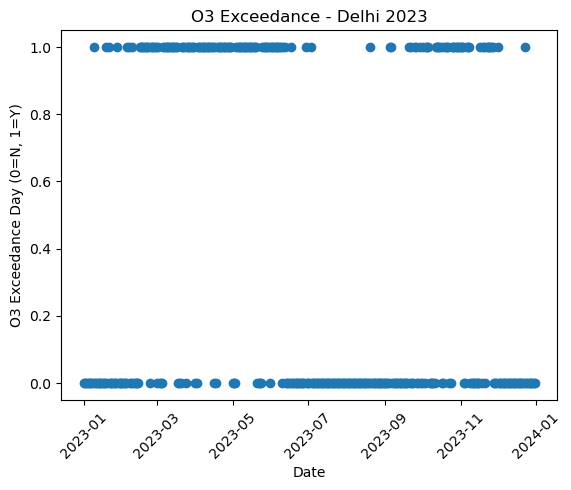

In [61]:
# Convert 'binary' column to numeric (0 for 'N' and 1 for 'Y')
o3_exceedance['binary_numeric'] = o3_exceedance['o3_exceedance'].map({'N': 0, 'Y': 1})
d = o3_exceedance[o3_exceedance.year==2023]
# Plot the dot plot
plt.plot(d['date'], d['binary_numeric'], marker='o', linestyle='None')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('O3 Exceedance Day (0=N, 1=Y)')
plt.title('O3 Exceedance - Delhi 2023')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()


# Season plots

In [110]:
station_name = 'Alipur, Delhi - DPCC'
india_naaqs_o3 = 100
mda8_station = mda8[mda8['location_name'] == station_name].reset_index()
mda8_station['date'] = pd.to_datetime(mda8_station['date'])

mda8_station['year'] = mda8_station.date.dt.year
mda8_station['mm-yy'] = mda8_station['date'].dt.strftime('%b-%d') #Remove year from timestamp

mda8_station

,date,location_name,MDA,year,mm-yy
0,2019-01-01,"Alipur, Delhi - DPCC",57.881250,2019,Jan-01
1,2019-01-02,"Alipur, Delhi - DPCC",60.276042,2019,Jan-02
2,2019-01-03,"Alipur, Delhi - DPCC",51.006250,2019,Jan-03
3,2019-01-04,"Alipur, Delhi - DPCC",27.103125,2019,Jan-04
4,2019-01-05,"Alipur, Delhi - DPCC",49.873958,2019,Jan-05
...,...,...,...,...,...
1731,2023-12-27,"Alipur, Delhi - DPCC",15.967083,2023,Dec-27
1732,2023-12-28,"Alipur, Delhi - DPCC",22.984792,2023,Dec-28
1733,2023-12-29,"Alipur, Delhi - DPCC",18.927500,2023,Dec-29
1734,2023-12-30,"Alipur, Delhi - DPCC",33.490625,2023,Dec-30


In [111]:
mda_station_pivot = pd.pivot_table(mda8_station,
                          index=['mm-yy'],
                          columns='year',
                          values='MDA').reset_index()
mda_station_pivot.set_index('mm-yy',inplace=True)
mda_station_pivot

year,2019,2020,2021,2022,2023
mm-yy,,,,,
Apr-01,85.990625,47.850000,91.949375,33.768750,NaN
Apr-02,118.496875,46.415625,95.276875,39.305000,NaN
Apr-03,99.300000,58.809375,115.670000,41.980000,97.715208
Apr-04,140.028125,55.469792,102.368125,34.450000,98.071042
Apr-05,103.098958,63.150000,167.688958,34.821458,89.078423
...,...,...,...,...,...
Sep-26,21.509375,4.042969,29.218125,3.675000,83.720625
Sep-27,20.478125,6.071875,38.058125,3.025000,68.097292
Sep-28,23.556250,6.481250,36.011250,3.325000,83.022500


In [112]:
## SORT THE  DATETIME INDEX WHICH IS IN STRING FORMAT ##
# Convert the index to datetime
mda_station_pivot.index = pd.to_datetime(mda_station_pivot.index + '-2000', format='%b-%d-%Y')
# Sort the DataFrame by the datetime index
mda_station_pivot = mda_station_pivot.sort_index()
# Remove the year from the index
mda_station_pivot.index = mda_station_pivot.index.strftime('%b-%d')
mda_station_pivot

year,2019,2020,2021,2022,2023
mm-yy,,,,,
Jan-01,57.881250,63.317708,29.362500,24.332500,75.638750
Jan-02,60.276042,56.087500,32.743750,26.603750,45.988333
Jan-03,51.006250,69.683333,34.523750,38.102917,44.576250
Jan-04,27.103125,61.727083,27.333750,26.462500,43.787083
Jan-05,49.873958,69.037500,27.090000,14.516875,24.903125
...,...,...,...,...,...
Dec-27,17.581250,84.456250,23.888750,56.907500,15.967083
Dec-28,28.256250,61.153125,12.672917,83.216667,22.984792
Dec-29,55.284375,68.045833,20.857292,98.663125,18.927500


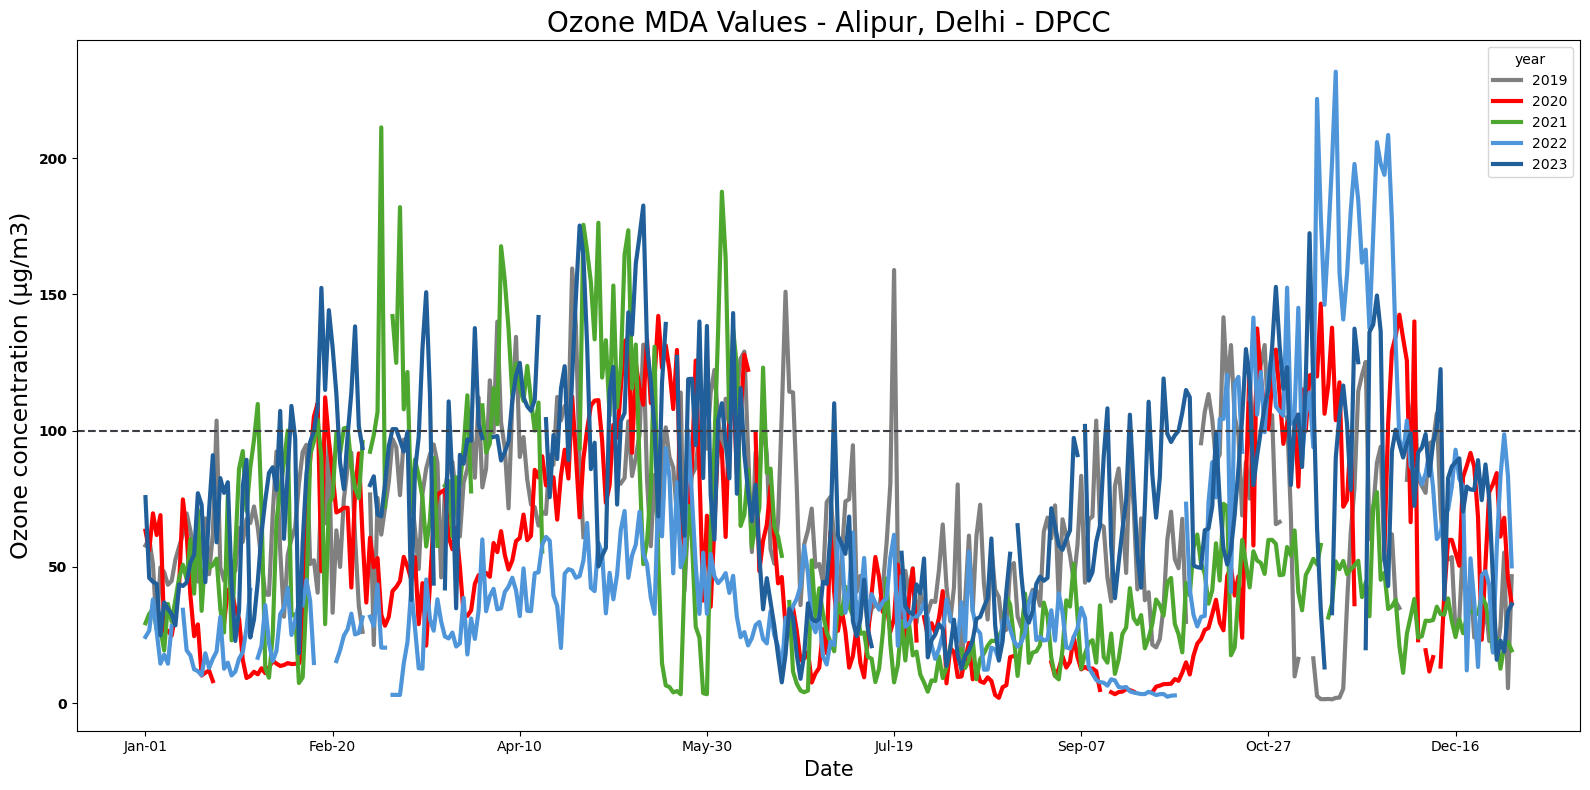

In [115]:
color_dict = {
              2019: '#808080',
              2020: '#ff0000',
              2021: '#4ea72e',
              2022: '#4e95d9',
              2023: '#215f9a',
              }
mda_station_pivot.plot(figsize=(16, 8),
                       color=[color_dict.get(x) for x in mda_station_pivot.columns],
                       linewidth = 3)

plt.title('Ozone MDA Values - {}'.format(station_name), fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Ozone concentration (μg/m3)', fontsize=17)

plt.yticks(fontweight='bold', fontsize=10)

plt.axhline(y=india_naaqs_o3, color='#3B3F44', linestyle='--')

# Add data source annotation
#data_source_annotation = '''Data sourcsed from official AQI Bulletins'''

#plt.text(0.01, 0.02, data_source_annotation, fontsize=8, color='gray', transform=plt.gcf().transFigure)

# Load the image
#logo = plt.imread('assets/logo.grid.3_transp.png')  # Provide the path to your image file
#plt.figimage(logo, xo=1500, yo=0.02)
plt.tight_layout()
#plt.savefig('visuals/seasonplot_aqi.png')
plt.show()